In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from nnfs.datasets import spiral_data 
import nnfs 
nnfs.init()

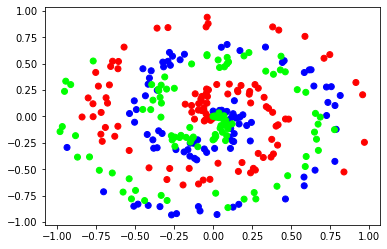

In [5]:

X, y = spiral_data(samples = 100, classes = 3) 
plt.scatter(X[:,0], X[:,1], c=y, cmap='brg') 
plt.show()

In [6]:
import numpy as np

class Layer_Dense:
    
    def __init__(self, n_inputs, n_neurons, weight_regularizer_l1=0, weight_regularizer_l2=0, bias_regularizer_l1=0, bias_regularizer_l2=0):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1,n_neurons))
        
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2
    
    def forward(self, inputs):
        self.output = np.dot(inputs, self.weights) + self.biases
        self.inputs = inputs
        
    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T,dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        
        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones(self.weights.shape)
            dL1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dL1
        
        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * self.weights
    
        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones(self.biases.shape)
            dL1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dL1
        
        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * self.biases
        
        self.dinputs = np.dot(dvalues, self.weights.T)

class Layer_Dropout:
    
        def __init__(self, rate):
            # We will be using droput rate and invert for success rate
            self.rate = 1 - rate
        
        def forward(self, inputs):
            self.inputs = inputs
            
            self.binary_mask = np.random.binomial(1, self.rate, size = inputs.shape) / self.rate
            
            self.output = inputs * self.binary_mask
        
        def backward(self, dvalues):
            self.dinputs = self.binary_mask * dvalues
        
             
    
        
class Activation_ReLu:
    
    def forward(self, inputs):
        self.output = np.maximum(0,inputs)
        self.inputs = inputs
    
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        
        self.dinputs[self.inputs <= 0] = 0
        
class Activation_Softmax:
    
    def forward(self, inputs):
        exp_values = np.exp(inputs - np.max(inputs, axis= 1, keepdims=True))
        
        probabilities = exp_values / np.sum(exp_values, axis=1,keepdims=True)
        
        self.output = probabilities
    
    def backward(self,dvalues):
        self.dinputs = np.empty_like(dvalues)
        
        for index, (single_output, single_dvalue) in enumerate(zip(self.output, dvalues)):
            single_output = single_output.reshape(-1,1)
            
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output,single_output.T)
            
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalue)

class Optimizer_SDG:
    
    def __init__(self,learning_rate=1, learning_rate_decay = 0, momentum = 0):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.learning_rate_decay = learning_rate_decay
        self.steps = 0
        self.momentum = momentum
        
    def pre_update_params(self):
        # Update current learning rate if there is a decay function
        if self.learning_rate_decay:
            self.current_learning_rate = self.learning_rate * (1/ (1+self.learning_rate_decay*self.steps))
        
    def update_params(self,layer):
        if self.momentum:
            
            if not hasattr(layer, 'weight_momentums'):
                # Store momentums in the layer
                layer.weight_momentums = np.zeros_like(layer.weights)
                
                layer.bias_momentums = np.zeros_like(layer.biases)

            # Update with momentums
            weight_updates = self.momentum * layer.weight_momentums - self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates
            
            bias_updates = self.momentum * layer.bias_momentums - self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates
        
        else:
            # Normal update
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates = -self.current_learning_rate * layer.dbiases
        
        layer.weights +=  weight_updates
        layer.biases +=  bias_updates
    
    def post_update_params(self):
        self.steps += 1
        
class Optimizer_AdaGrad:
    
    def __init__(self,learning_rate=1, learning_rate_decay = 0,epsilon = 1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.learning_rate_decay = learning_rate_decay
        self.steps = 0
        self.epsilon = epsilon
        
    def pre_update_params(self):
        # Update current learning rate if there is a decay function
        if self.learning_rate_decay:
            self.current_learning_rate = self.learning_rate * (1/ (1+self.learning_rate_decay*self.steps))
        
    def update_params(self,layer):
        if not hasattr(layer, 'weight_cache'):
            # Store caches in the layer
            layer.weight_cache = np.zeros_like(layer.weights)
                
            layer.bias_cache = np.zeros_like(layer.biases)
            
        layer.weight_cache += layer.dweights ** 2
        layer.bias_cache += layer.dbiases **2
        
        layer.weights +=  -self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases +=  -self.current_learning_rate * layer.dbiases / (np.sqrt(layer.bias_cache) + self.epsilon)
    
    def post_update_params(self):
        self.steps += 1
        
class Optimizer_RMSprop:
    
    def __init__(self,learning_rate=0.001, learning_rate_decay = 0,epsilon = 1e-7, rho = 0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.learning_rate_decay = learning_rate_decay
        self.steps = 0
        self.epsilon = epsilon
        self.rho = rho
        
    def pre_update_params(self):
        # Update current learning rate if there is a decay function
        if self.learning_rate_decay:
            self.current_learning_rate = self.learning_rate * (1/ (1+self.learning_rate_decay*self.steps))
        
    def update_params(self,layer):
        if not hasattr(layer, 'weight_cache'):
            # Store caches in the layer
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
            
        layer.weight_cache = self.rho * layer.weight_cache + (1 - self.rho) * layer.dweights ** 2
        layer.bias_cache = self.rho * layer.bias_cache + (1 - self.rho) * layer.dbiases ** 2
        
        layer.weights +=  -self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases +=  -self.current_learning_rate * layer.dbiases / (np.sqrt(layer.bias_cache) + self.epsilon)
    
    def post_update_params(self):
        self.steps += 1
        
class Optimizer_Adam:
    
    def __init__(self,learning_rate=0.001, learning_rate_decay = 0,epsilon = 1e-7, beta_1 = 0.9, beta_2 = 0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.learning_rate_decay = learning_rate_decay
        self.steps = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        
    def pre_update_params(self):
        # Update current learning rate if there is a decay function
        if self.learning_rate_decay:
            self.current_learning_rate = self.learning_rate * (1/ (1+self.learning_rate_decay*self.steps))
        
    def update_params(self,layer):
        if not hasattr(layer, 'weight_cache'):
            # Store momentums and caches in the layer
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)
        
        # Update momentums
        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1-self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1-self.beta_1) * layer.dbiases
        
        # Corrected momentums (1 - b_1^step)
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.steps + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.steps + 1))
        
        # Update Cache
        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights ** 2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases ** 2
        
        # Corrected cache (1 - b_2^step)
        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.steps + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.steps + 1))
        
        layer.weights +=  -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases +=  -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)
    
    def post_update_params(self):
        self.steps += 1

class Loss:
    
    def calculate(self,output,y):
        sample_losses = self.forward(output,y)
        
        data_loss = np.mean(sample_losses)
        
        return data_loss
    
    def regularization_loss(self,layer):
        regularization_loss = 0
        
        if layer.weight_regularizer_l1 > 0:
            regularization_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))  
        
        if layer.weight_regularizer_l2 > 0:
            regularization_loss +=  layer.weight_regularizer_l2 * np.sum(layer.weights * layer.weights) 
        
        if layer.bias_regularizer_l1 > 0:
            regularization_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))  
        
        if layer.bias_regularizer_l2 > 0:
            regularization_loss +=  layer.bias_regularizer_l2 * np.sum(layer.biases * layer.biases)  
            
        return regularization_loss


class Loss_CategoricalCrossentropy(Loss):
    
    def forward(self, y_pred, y_true):
        
        samples = len(y_pred)
        
        y_pred_clipped = np.clip(y_pred, 1e-7, 1- 1e-7)
        
        if len(y_true.shape) == 1: 
            correct_confidences = y_pred_clipped[ 
                range(samples), 
                y_true 
            ] 
 
        
        elif len(y_true.shape) == 2: 
            correct_confidences = np.sum( 
                y_pred_clipped * y_true, 
                axis = 1 
            ) 
 
        
        negative_log_likelihoods = -np.log(correct_confidences) 
        return negative_log_likelihoods
    
    def backward(self, dvalues, y_true):
       
        samples = len(dvalues) 
        
        labels = len(dvalues[0]) 
 
        
        if len(y_true.shape) == 1: 
            y_true = np.eye(labels)[y_true] 
 
        
        self.dinputs = -y_true / dvalues 
        
        self.dinputs = self.dinputs / samples 
        
class Activation_Softmax_Loss_CategoricalCrossentropy:
    
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()
        
    def forward(self, inputs, y_true):
        self.activation.forward(inputs)
        self.output = self.activation.output
        
        return self.loss.calculate(self.output, y_true)
    
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        
        if (len(y_true.shape)==2):
            y_true = np.argmax(y_true, axis = 1)
        
        self.dinputs = dvalues.copy()
        
        self.dinputs[range(samples), y_true] -= 1
        
        self.dinputs = self.dinputs / samples

class Acuracy:
    
    def calculate(self, inputs, y_true):
        
        predictions = np.argmax(inputs, axis=1)
        
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
            
        acuracy = np.mean(predictions==y_true)
        return acuracy
        



Training model

In [15]:
#Data
X, y = spiral_data(samples = 100, classes = 3) 

#First layer with 2 inputs and 64 neurons
dense1 = Layer_Dense(2,512, weight_regularizer_l2=5e-4, bias_regularizer_l2=5e-4)

#ReLu for first layer
activation1 = Activation_ReLu()

dropout1 = Layer_Dropout(0.1) 

#Second layer with 64 inputs(As it uses the outputs from the previous layer) and 3 neurons
dense2 = Layer_Dense(512,3)

#Softmax with loss for backpropagation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

#SDG Optimizer
optimizer = Optimizer_Adam(learning_rate=0.05, learning_rate_decay=5e-5)

#Create acuracy function 
acuracy_function = Acuracy()

for epoch in range(10001):
    #Forward of our data on the first layer
    dense1.forward(X)

    #ReLu activation of the data in the first layer
    activation1.forward(dense1.output)
    
    dropout1.forward(activation1.output)

    #Forward of our outputs fron the ReLu of the first layer
    dense2.forward(dropout1.output)


    data_loss = loss_activation.forward(dense2.output, y)
    regularizarion_loss = loss_activation.loss.regularization_loss(dense1) + loss_activation.loss.regularization_loss(dense2)
    loss = data_loss + regularizarion_loss

    #Acuracy function of the data of the softmax
    accuracy = acuracy_function.calculate(loss_activation.output, y)

    
    if not epoch % 100: 
        print(f'epoch: {epoch}, ' + 
              f'acc: {accuracy:.3f}, ' + 
              f'loss: {loss:.3f} ( ' +
              f'data_loss: {data_loss:.3f}, '+
              f'regularizarion_loss: {regularizarion_loss:.3f} )'+
              f'lr: {optimizer.current_learning_rate}') 

    # Backward pass 
    loss_activation.backward(loss_activation.output, y) 
    dense2.backward(loss_activation.dinputs)
    dropout1.backward(dense2.dinputs)
    activation1.backward(dropout1.dinputs) 
    dense1.backward(activation1.dinputs) 

    #Using sdg to update params
    optimizer.pre_update_params()
    optimizer.update_params(dense1) 
    optimizer.update_params(dense2) 
    optimizer.post_update_params()


epoch: 0, acc: 0.340, loss: 1.099 ( data_loss: 1.099, regularizarion_loss: 0.000 )lr: 0.05
epoch: 100, acc: 0.710, loss: 0.726 ( data_loss: 0.659, regularizarion_loss: 0.067 )lr: 0.04975371909050202
epoch: 200, acc: 0.730, loss: 0.638 ( data_loss: 0.549, regularizarion_loss: 0.089 )lr: 0.049507401356502806
epoch: 300, acc: 0.793, loss: 0.609 ( data_loss: 0.514, regularizarion_loss: 0.094 )lr: 0.0492635105177595
epoch: 400, acc: 0.783, loss: 0.598 ( data_loss: 0.500, regularizarion_loss: 0.097 )lr: 0.04902201088288642
epoch: 500, acc: 0.783, loss: 0.611 ( data_loss: 0.509, regularizarion_loss: 0.102 )lr: 0.048782867456949125
epoch: 600, acc: 0.813, loss: 0.552 ( data_loss: 0.450, regularizarion_loss: 0.102 )lr: 0.04854604592455945
epoch: 700, acc: 0.817, loss: 0.561 ( data_loss: 0.460, regularizarion_loss: 0.102 )lr: 0.048311512633460556
epoch: 800, acc: 0.793, loss: 0.580 ( data_loss: 0.479, regularizarion_loss: 0.101 )lr: 0.04807923457858551
epoch: 900, acc: 0.833, loss: 0.536 ( data_

In [20]:
#Data
X_test, y_test = spiral_data(samples = 100, classes = 3) 

#Forward of our data on the first layer
dense1.forward(X_test)

#ReLu activation of the data in the first layer
activation1.forward(dense1.output)

#Forward of our outputs fron the ReLu of the first layer
dense2.forward(activation1.output)


data_loss = loss_activation.forward(dense2.output, y_test)

loss = data_loss

#Acuracy function of the data of the softmax
accuracy = acuracy_function.calculate(loss_activation.output, y)
    
print(f'epoch: {epoch}, ' + 
        f'acc: {accuracy:.3f}, ' + 
        f'loss: {loss:.3f}, ') 


epoch: 10000, acc: 0.820, loss: 0.430, 


In [ ]:
weights = np.array([[0.2, 0.8, -0.5, 1], 
                    [0.5, -0.91, 0.26, -0.5], 
                    [-0.26, -0.27, 0.17, 0.87]]) 

dL1 = np.ones(weights.shape)
dL1[weights < 0] = -1
dL1

array([[ 1.,  1., -1.,  1.],
       [ 1., -1.,  1., -1.],
       [-1., -1.,  1.,  1.]])